In [1]:
%env CUDA_VISIBLE_DEVICES=5

env: CUDA_VISIBLE_DEVICES=5


In [2]:
import numpy as np
import cupy as cp

In [3]:
xp = np

X = 1000
Y = 1000
Z = 20

data = np.random.rand(X,Y,Z).astype('float32')

# numpy

In [4]:
def vectors_comparison(vector1, vector2, data_stds, shifted_stds):
    res = xp.multiply(vector1, vector2)
    res = xp.sum(xp.power(res, 2), axis = 2)
#     res = xp.multiply(res, data_stds)
#     res = xp.multiply(res, shifted_stds)
    return res

In [5]:
data = data = np.random.randint(0, 2, (X,Y,Z)).astype('float32')
bad_traces=np.zeros(data.shape[:2])
bad_traces = np.random.binomial(1, 0.01, size=bad_traces.shape)
# check with bad traces

In [6]:
data_stds = data.std(axis=-1)
tmp_bad_traces = bad_traces.copy()
tmp_bad_traces[data_stds == 0.0] = 1

In [7]:
np.any(tmp_bad_traces==1)

True

In [8]:
np.all(tmp_bad_traces==1)

False

# old

In [9]:
def compute_local(function, data, bad_traces, kernel_size=3,
                      normalize=True, agg='mean', amortize=False, axis=0, device='cpu', pbar=None):
        i_range, x_range = data.shape[:2]
        k = kernel_size // 2

        # Transfer to GPU, if needed
        data = to_device(data, device)
        bad_traces = to_device(bad_traces, device)
        xp = cp.get_array_module(data) if (cp is not np) else np

        # Compute data statistics
        data_stds = data.std(axis=-1)
        bad_traces[data_stds == 0.0] = 1
        if normalize:
            data_n = data - data.mean(axis=-1, keepdims=True)
        else:
            data_n = data

        # Pad everything
        padded_data = xp.pad(data_n, ((k, k), (k, k), (0, 0)), constant_values=xp.nan)
        padded_stds = xp.pad(data_stds, k, constant_values=0.0)
        padded_bad_traces = xp.pad(bad_traces, k, constant_values=1)
        
        # Compute metric by shifting arrays
        total = kernel_size * kernel_size - 1
        pbar = Notifier(pbar, total=total) if pbar else None

        accumulator = Accumulator(agg=agg, amortize=amortize, axis=axis, total=total)
        for i in range(kernel_size):
            for j in range(kernel_size):
                if i == j == k:
                    continue

                shifted_data = padded_data[i:i+i_range, j:j+x_range]
                shifted_stds = padded_stds[i:i+i_range, j:j+x_range]
                shifted_bad_traces = padded_bad_traces[i:i+i_range, j:j+x_range]

                computed = function(data_n, shifted_data, data_stds, shifted_stds)
                computed[shifted_bad_traces == 1] = xp.nan

                accumulator.update(computed)
                if pbar:
                    pbar.update()
        if pbar:
            pbar.close()

        result = accumulator.get(final=True)
        return from_device(result)

In [10]:
import sys
sys.path.append("/notebooks") 
sys.path.append("..")

In [11]:
from seismiqb.src.utility_classes import Accumulator
from seismiqb.src.functional import to_device, from_device
from batchflow.notifier import Notifier

In [12]:
data_n = data

In [13]:
# %%timeit -o
res_old_copy = compute_local(function=vectors_comparison, data=data_n.copy(), bad_traces=bad_traces.copy(), kernel_size=3,
                      normalize=False, agg='nanmean', amortize=False, axis=0, device='cpu', pbar=True)

100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  4.06it/s]


In [14]:
# times = _
# timings = times.timings

In [15]:
from seismiqb import metrics

In [16]:
res_old = metrics.BaseMetrics.compute_local(_, function=vectors_comparison, data=data_n.copy(), bad_traces=bad_traces.copy(), kernel_size=3,
                      normalize=False, agg='nanmean', amortize=False, axis=0, device='cpu', pbar=True)

100%|█████████████████████████████████████████████| 8/8 [00:02<00:00,  3.95it/s]


In [17]:
np.allclose(res_old_copy, res_old, equal_nan=True)

True

In [18]:
# def compute_local(function, data, bad_traces, kernel_size=3,
#                       normalize=True, agg='mean', amortize=False, axis=0, device='cpu', pbar=None):
#         i_range, x_range = data.shape[:2]
#         k = kernel_size // 2

#         # Transfer to GPU, if needed
#         data = to_device(data, device)
#         bad_traces = to_device(bad_traces, device)
#         xp = cp.get_array_module(data) if (cp is not np) else np

#         # Compute data statistics
#         data_stds = data.std(axis=-1)
#         bad_traces[data_stds == 0.0] = 1
        
#         if normalize:
#             data_n = data - data.mean(axis=-1, keepdims=True)
#         else:
#             data_n = data
            
#         data_n[bad_traces == 1] = xp.nan

#         # Pad everything
#         padded_data = xp.pad(data_n, ((k, k), (k, k), (0, 0)), constant_values=xp.nan)
#         padded_stds = xp.pad(data_stds, k, constant_values=0.0)
#         padded_bad_traces = xp.pad(bad_traces, k, constant_values=1)
        
#         # Compute metric by shifting arrays
#         total = kernel_size * kernel_size - 1
#         pbar = Notifier(pbar, total=total) if pbar else None

#         accumulator = Accumulator(agg=agg, amortize=amortize, axis=axis, total=total)
#         for i in range(kernel_size):
#             for j in range(kernel_size):
#                 if i == j == k:
#                     continue

#                 shifted_data = padded_data[i:i+i_range, j:j+x_range]
#                 shifted_stds = padded_stds[i:i+i_range, j:j+x_range]
#                 shifted_bad_traces = padded_bad_traces[i:i+i_range, j:j+x_range]

#                 computed = function(data_n, shifted_data, data_stds, shifted_stds)
# #                 computed[shifted_bad_traces == 1] = xp.nan

#                 accumulator.update(computed)
#                 if pbar:
#                     pbar.update()
#         if pbar:
#             pbar.close()

#         result = accumulator.get(final=True)
#         return from_device(result)

In [19]:
# res_tmp = compute_local(function=vectors_comparison, data=data_n.copy(), bad_traces=bad_traces.copy(), kernel_size=3,
#                       normalize=False, agg='nanmean', amortize=False, axis=0, device='cpu', pbar=True)

In [20]:
# np.allclose(res, res_tmp)

In [21]:
# res

In [22]:
# res_tmp

In [23]:
# bad_traces

In [24]:
# data_stds = data_n.std(axis=-1)
# bad_traces[data_stds == 0.0] = 1

In [25]:
# bad_traces

# new

In [32]:
def compute_local_new(function, data, bad_traces, kernel_size=3,
                      normalize=True, agg='mean', amortize=False, axis=0, device='cpu', pbar=None):
        i_range, x_range = data.shape[:2]
        k = kernel_size // 2 + 1

        # Transfer to GPU, if needed
        data = to_device(data, device)
        bad_traces = to_device(bad_traces, device)
        xp = cp.get_array_module(data) if (cp is not np) else np

        # Compute data statistics
        data_stds = data.std(axis=-1)
        bad_traces[data_stds == 0.0] = 1
        if normalize:
            data_n = data - data.mean(axis=-1, keepdims=True)
        else:
            data_n = data

        # Pad everything
        padded_data = xp.pad(data_n, ((0, k), (k, k), (0, 0)), constant_values=xp.nan)
        padded_stds = xp.pad(data_stds, ((0, k), (k, k)), constant_values=0.0)
        padded_bad_traces = xp.pad(bad_traces, ((0, k), (k, k)), constant_values=1)

        # Compute metric by shifting arrays
        total = kernel_size * kernel_size - 1
        pbar = Notifier(pbar, total=total//2) if pbar else None

        accumulator = Accumulator(agg=agg, amortize=amortize, axis=axis, total=total)
        for i in range(k):
            for j in range(-k+1, k):
                if (i == 0) and (j <= 0):
                    continue                    
                shifted_data = padded_data[i:i+i_range, k+j:k+j+x_range]
                shifted_stds = padded_stds[i:i+i_range, k+j:k+j+x_range]
                shifted_bad_traces = padded_bad_traces[i:i+i_range, k+j:k+j+x_range]

                # Compute metric value for traces (x, y) and (x+i, y+j)
                computed = function(data, shifted_data, data_stds, shifted_stds)     
                
#                 computed[shifted_bad_traces == 1] = xp.nan


                # Shift comparison matrix and add padding for traces without pairs for comparison
                splitted_computed = computed[:i_range-i, max(0, -j):min(x_range, x_range-j)]
                shifted_computed = xp.pad(splitted_computed,
                                          ((i, 0), (max(0, j), -min(0, j))), 
                                          constant_values=xp.nan
                                         )

                computed[shifted_bad_traces == 1] = xp.nan                
                
                shifted_bad_traces = padded_bad_traces[:i_range, k:k+x_range]
                shifted_computed[shifted_bad_traces == 1] = xp.nan

                accumulator.update(computed)
                accumulator.update(shifted_computed)
                if pbar:
                    pbar.update()

        if pbar:
            pbar.close()

        result = accumulator.get(final=True)
        return from_device(result)

In [33]:
res_new = compute_local_new(function=vectors_comparison, data=data_n.copy(), bad_traces=bad_traces.copy(), kernel_size=3,
                      normalize=False, agg='nanmean', amortize=False, axis=0, device='cpu', pbar=True)


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.77it/s]


In [34]:
np.allclose(res_new, res_old, equal_nan=True)

False

In [35]:
np.mean(np.abs(res_new - res_old))

0.011136628571428572

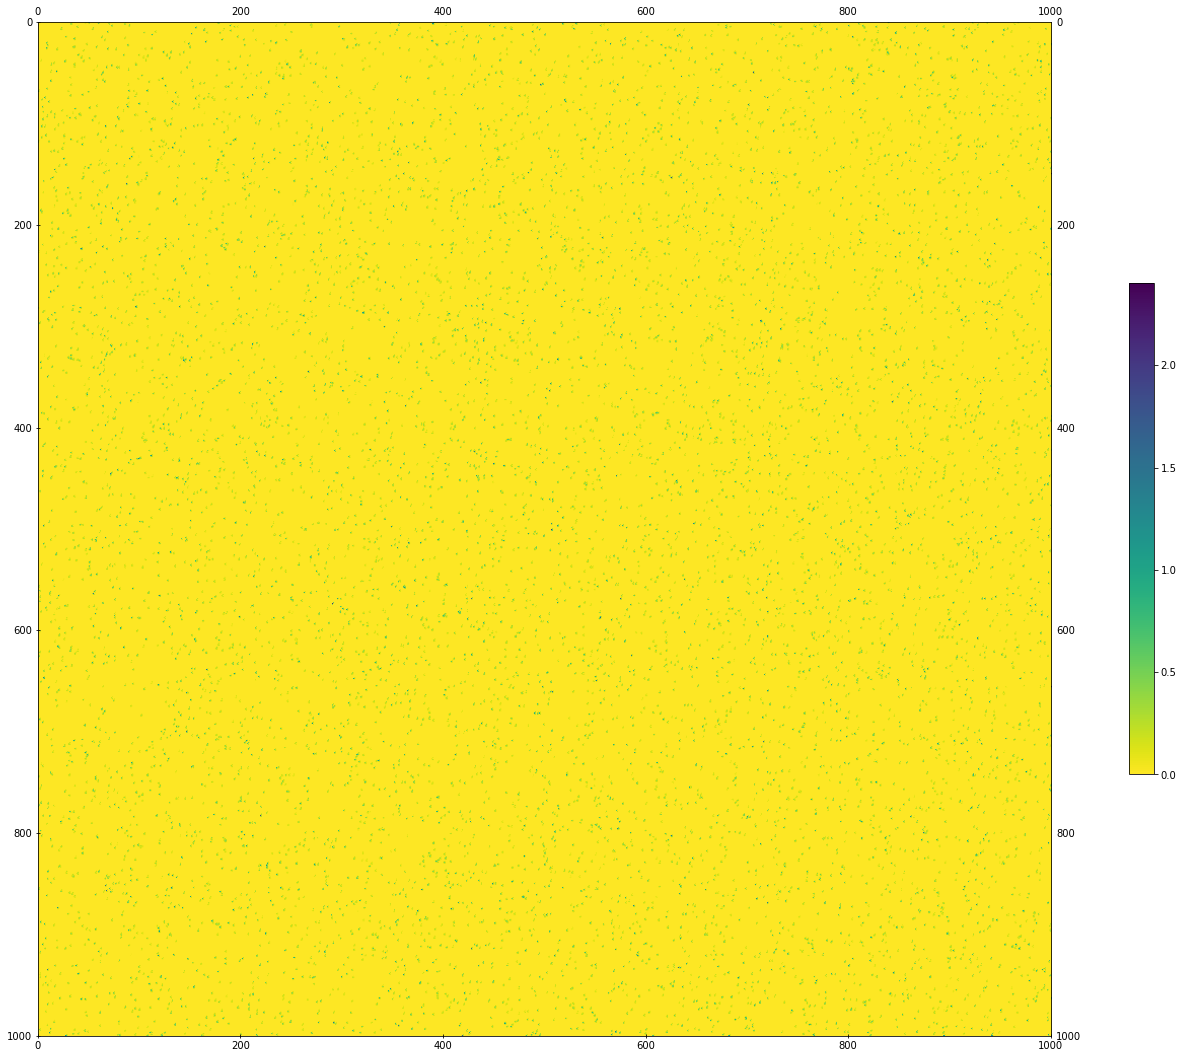

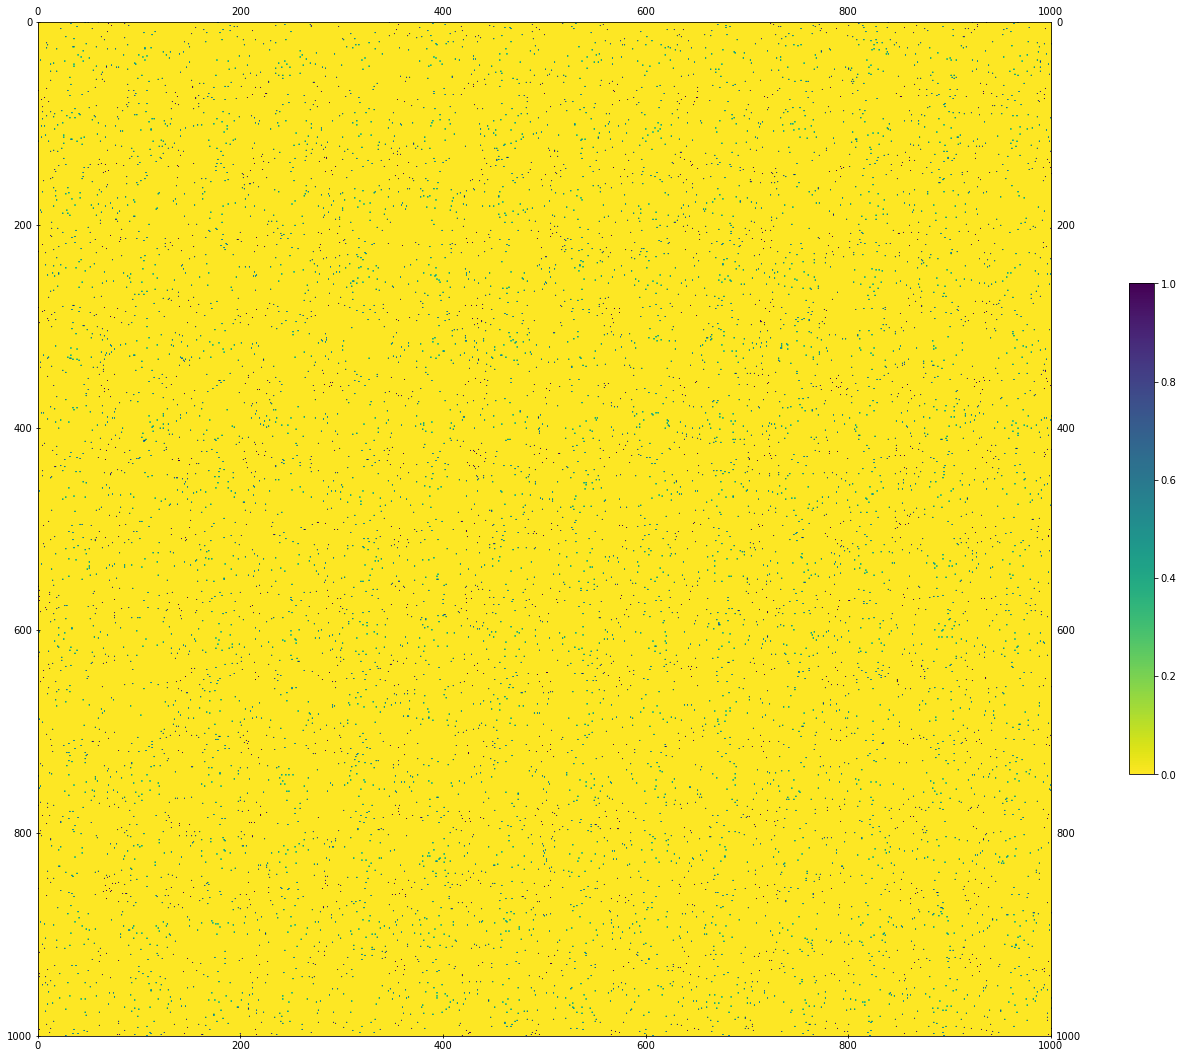

In [36]:
from seismiqb import plot_image
plot_image(np.abs(res_new - res_old), figsize=(20, 20))
plot_image(bad_traces, figsize=(20, 20))

In [ ]:
np.allclose(res_new, res_old_copy, equal_nan=True)

In [ ]:
# res

In [ ]:
# res2

In [ ]:
# tmp_bad_traces